## Application 2: Stock Price Forecasting

- Goal: Predict Facebook's closing stock price, one day in advance and one month in advance
- Refresh research question, math question
- Meet the data
- Simulation exercise:
  - Generate data with ARMA components
  - Use Python packages to fit models
  - Evaluate model fit with AIC/BIC
- Form predictions
  - Convert to stationary time series
  - Find a model fit, and validate with sample splitting
  - Form predictions


### Learning Goals

- Convert real-world dataset to stationary time series
- Recognize AR and MA components from ACF/PACF plots
- Fit AR and MA models
- Evaluate model fit using sample splitting
- Form predictions with AR/MA models
- Form confidence intervals around predictions


## General Approach

1. Pose research question (not covered in this recitation)
2. Find data (not covered in this recitation)
3. Translate research question to math question (see first video)
4. Select an appropriate model
5. Conduct analysis
6. Interpret results


## Stock Forecasting Research and Math Question

- Research Question: **Research Question: How well can we predict Facebook’s closing stock price one day in advance and one month in advance?**
- Math question: **Given the historical series of Facebook’s closing stock price, what is the best estimator of the stock price one day ahead or one month ahead? What is the test-sample mean squared error of each estimate?**


### Dataset: Stock Prices

Data is from Yahoo finance, which maintains a python package to retrieve daily stock prices.


All available NASDAQ listings: 
   Symbol                                       Company Name  \
0   AAIT  iShares MSCI All Country Asia Information Tech...   
1    AAL                      American Airlines Group, Inc.   
2   AAME                      Atlantic American Corporation   
3   AAOI                      Applied Optoelectronics, Inc.   
4   AAON                                         AAON, Inc.   

                                       Security Name Market Category  \
0  iShares MSCI All Country Asia Information Tech...               G   
1       American Airlines Group, Inc. - Common Stock               Q   
2       Atlantic American Corporation - Common Stock               G   
3       Applied Optoelectronics, Inc. - Common Stock               G   
4                          AAON, Inc. - Common Stock               Q   

  Test Issue Financial Status  Round Lot Size  
0          N                N           100.0  
1          N                N           100.0  
2          

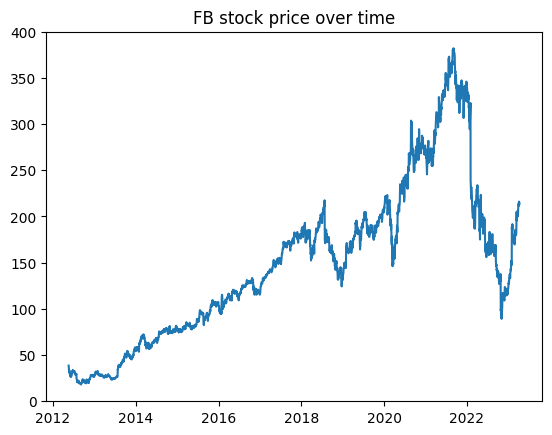

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import io
import yfinance as yf


url = "https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content

companies = pd.read_csv(io.StringIO(s.decode('utf-8')))
print("All available NASDAQ listings: \n", companies.head())

fb_series = yf.download("META", start='2009-06-01', progress=False)
print("Sample of META stock series: \n", fb_series.head())

price = fb_series.reset_index()['Close'].values.reshape(-1, 1)
date = fb_series.reset_index().Date.dt.date.values.reshape(-1, 1)

plt.plot(date, price)
plt.title("FB stock price over time")
plt.show()


### General Analysis Steps

1. Do we need to scale the data? _Yes, looks like the degree of variation is not constant over time_
2. Fit (non)linear trend to the data? _Yes, looks like there's a trend to the data_
3. Fit seasonal components?
4. Fit external regressors?
5. Fit AR/MA model?


### Transforming data

Here, the variance of the data is not constant over time.
This violates one of the assumptions of stationarity.
We can correct by taking a log transformation of the data - now, the variance looks more consistent over the time series.


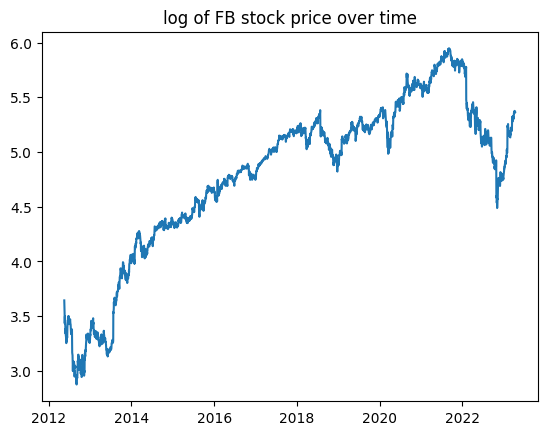

In [2]:
# Applying log transformation
log_price = np.log(price)
plt.plot(date, log_price)
plt.title("log of FB stock price over time")
plt.show()


#### Information Criteria

We covered these more in the last video - reusing the same code.

Idea: find a balance between model fit and complexity.

AIC (Akaike Information Criteria): $-2 * \text{log-likelihood} + 2k$

BIC (Bayesian Information Criteria): $-2 * \text{log-likelihood} + k \log(n)$

where $k$ is the model complexity (degrees of freedom used up) and $n$ is the number of elements.

A good practice is to select a model that minimizes both of these criteria; when they disagree, turn to another approach like out-of-sample validation.


In [3]:
# Example here about how to find; what my assumption is behind this
from scipy.stats import norm


def evaluate_AIC(k, residuals):
    """
    Finds the AIC given the number of parameters estimated and 
    the residuals of the model. Assumes residuals are distributed 
    Gaussian with unknown variance. 
    """
    standard_deviation = np.std(residuals)
    log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
    return 2 * k - 2 * np.sum(log_likelihood)


def evaluate_BIC(k, residuals):
    """
    Finds the AIC given the number of parameters estimated and 
    the residuals of the model. Assumes residuals are distributed 
    Gaussian with unknown variance. 
    """
    standard_deviation = np.std(residuals)
    log_likelihood = norm.logpdf(residuals, 0, scale=standard_deviation)
    return k * np.log(len(residuals)) - 2 * np.sum(log_likelihood)


### Start with a linear model:


[[0.0008012]]


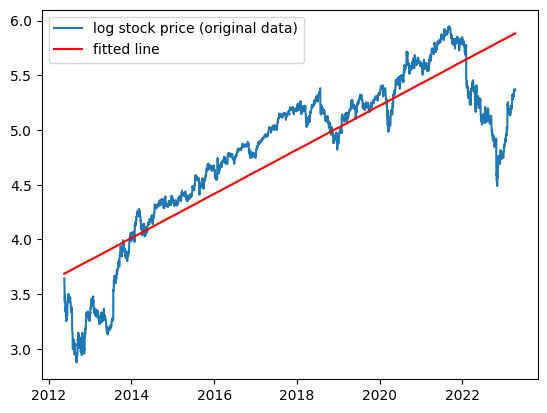

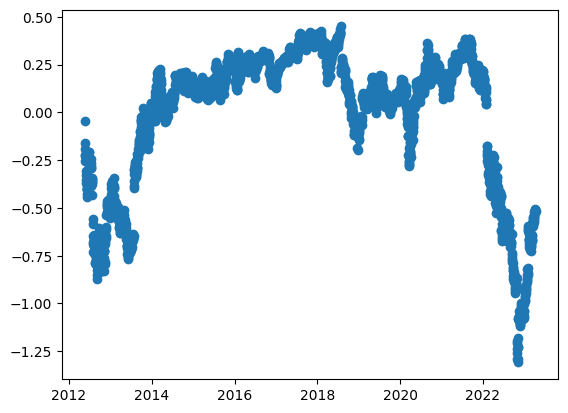

MSE with linear fit: 0.13114058490786776
AIC: 2212.3196563652536
BIC: 2218.2357344615566


In [4]:

from sklearn import linear_model
clf = linear_model.LinearRegression()
index = fb_series.reset_index().index.values.reshape(-1, 1)

clf.fit(index, log_price)
print(clf.coef_)  # To print the coefficient estimate of the series.
linear_prediction = clf.predict(index)
plt.plot(date, log_price, label='log stock price (original data)')
plt.plot(date, linear_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
linear_residuals = log_price - linear_prediction
plt.plot(date, linear_residuals, 'o')
plt.show()
print("MSE with linear fit:", np.mean((linear_residuals)**2))
print("AIC:", evaluate_AIC(1, linear_residuals))
print("BIC:", evaluate_BIC(1, linear_residuals))


### After linear fit, it seems like a higher order model is needed


[[ 2.25079419e-03 -5.29048183e-07]]


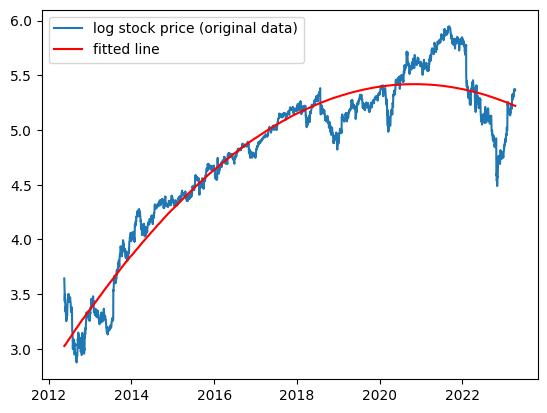

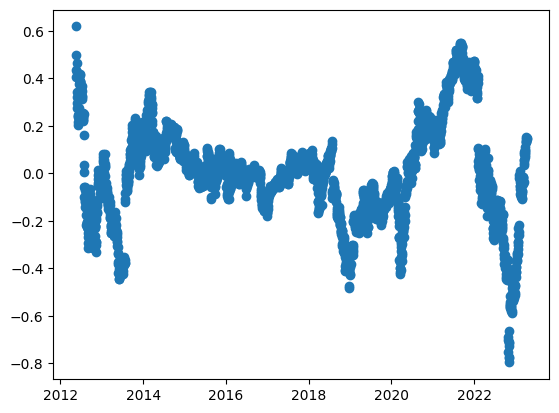

MSE with quadratic fit: 0.04336902800087181
AIC: -818.6636395945284
BIC: -806.8314834019228


In [5]:
# After linear fit, it seems like a higher order model is needed
from sklearn import linear_model
clf = linear_model.LinearRegression()
index = fb_series.reset_index().index.values.reshape(-1, 1)

new_x = np.hstack((index, index ** 2))
clf.fit(new_x, log_price)
print(clf.coef_)  # To print the coefficient estimate of the series.
quad_prediction = clf.predict(new_x)
plt.plot(date, log_price, label='log stock price (original data)')
plt.plot(date, quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
quad_residuals = log_price - quad_prediction
plt.plot(date, quad_residuals, 'o')
plt.show()
print("MSE with quadratic fit:", np.mean((quad_residuals)**2))
print("AIC:", evaluate_AIC(2, quad_residuals))
print("BIC:", evaluate_BIC(2, quad_residuals))


### This looks like a satisfactory model for the trend


## Examine ACF/PACF

This tells us about existence of periodic components, or AR/MA models.


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


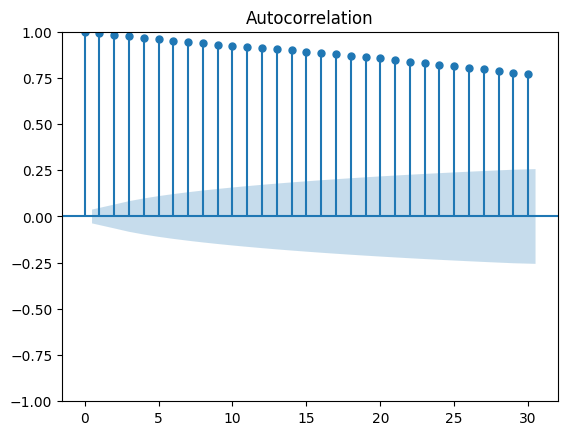

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


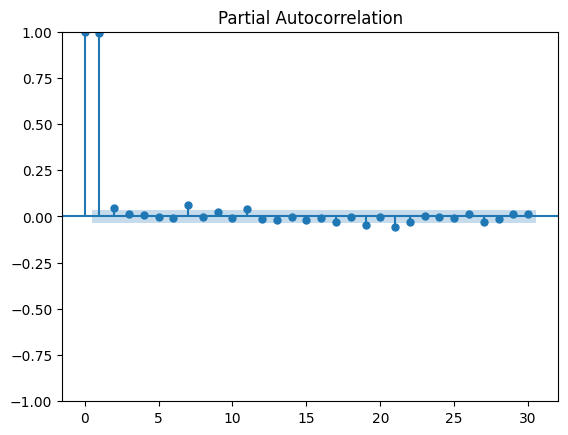

In [6]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(quad_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(quad_residuals, lags=30)
plt.show()


## Interpretation:

After taking a log transformation of the data, and removing a quadratic trend, there's a pattern in the ACF/PACF plots we didn't see in the last video.

Strong first term in PACF, exponentially decaying ACF.
From lecture, you may recognize this pattern as evidence of an AR(1) component.

It's important to model these terms, because AR/MA can change the error structure, if analysis of coefficients is important. It can also change how we make forecasts, and our confidence bands on those forecasts.

But how do we deal with this? To figure out, let's work through an example with simulated data first.


## Simulated Data

To review AR/MA models, we're going to do an exercise with simulated data first.


### ARMA Models

Recall the general form for an AR model of order $p$:
$$X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} \dots + \phi_p X_{t - p} + \varepsilon_t$$

And the form for an MA model of order $q$:
$$X_t = \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} \dots + \theta_q \varepsilon_{t-q}$$

where $ɛ_t$ is mean zero white noise that's uncorrelated with any lagged or future values.

$X_t$ is the value of the time series, and is typically the only thing you observe.

$\phi$ and $\theta$ are parameters to be estimated.


### Simulate Dataset

First, we simulate a dataset with random noise and AR/MA terms.

There's some technical constraints about when an AR/MA series is stationary, and whether you can recover the MA terms from the series (invertibility) - you don't have to worry about these, but to run these simulations, I'm making sure that the time series is stationary so that the ARIMA packages can recover the parameters.


_Optional: Generating Stationary AR Series_

I use the condition that the characteristic polynomial must have roots outside the unit circle.

For an order-$p$ time series $X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} \dots + \phi_p X_{t - p}$, there is a **characteristic polynomial** $\Phi(X_t) := 1 - \sum_{i=1}^p \phi_i X_{t-i}$.
Note that we can equivalently express this polynomial as $\Phi(X_t) = \prod_{i=1}^p (1 - \alpha_i L) X_t$ where $L$ is the lag operator (i.e. $L(X_t) = X_{t-1}$.
By fixing all $\alpha_i = R$, for some constant $R \in (-1,1)$, we guarantee the time series is stationary.

See [this link](https://math.unm.edu/~ghuerta/tseries/week4_1.pdf) for more details.


In [7]:
import statsmodels.api as sm
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()


def sim_dataset(AR, MA, t=100, trend=None, polynomial_root=-0.5, MA_weight=0.5):
    """
    Simulates a dataset given AR or MA order. 
    Selects AR terms so that the polynomial root is the given value;
    as long as the root is within (-1, 1), the series will be stationary. 
    """
    if trend is None:
        def trend(x): return 0
    arparams = np.array([comb(AR, i)*(polynomial_root)**(i)
                        for i in range(1, AR + 1)])
    maparams = np.array([MA_weight] * MA)
    ar = np.r_[1, arparams]  # add zero-lag
    ma = np.r_[1, maparams]  # add zero-lag
    arma_process = sm.tsa.ArmaProcess(ar, ma)
    print("ARMA process is stationary: ", arma_process.isstationary)
    print("ARMA process is invertible: ", arma_process.isinvertible)
    y = arma_process.generate_sample(t)
    y = np.array([_y + trend(j) for j, _y in enumerate(y)])
    return y


#### White noise

ACF: no clear pattern after first term
PACF: no clear pattern after first term


ARMA process is stationary:  True
ARMA process is invertible:  True


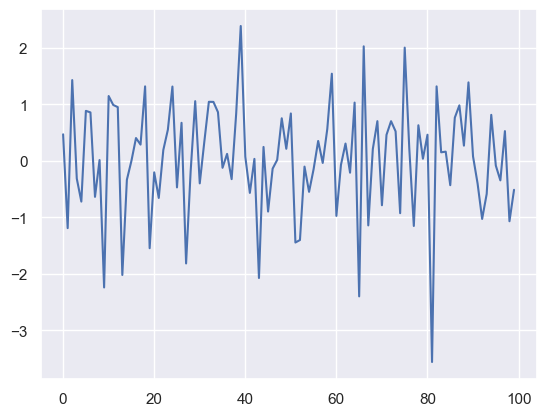

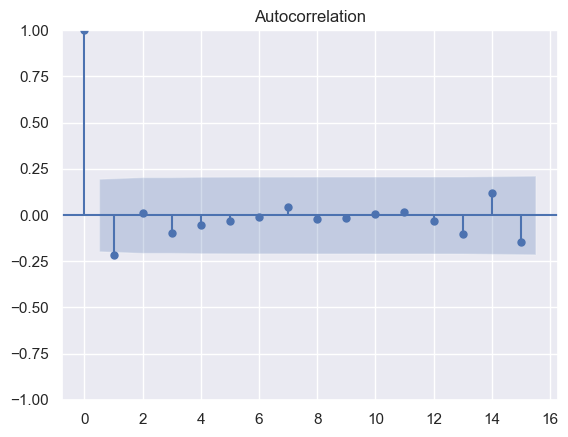

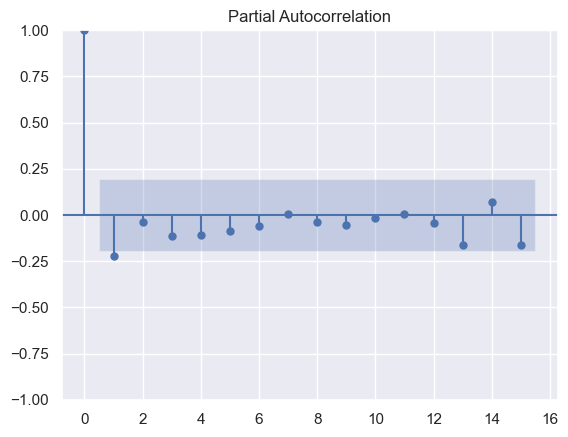

In [9]:
np.random.seed(1234)
white_noise = sim_dataset(0, 0, 100)
plt.plot(white_noise)
plt.show()
sm.graphics.tsa.plot_acf(white_noise, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(white_noise, lags=15)
plt.show()


#### AR

ACF: Exponentially decaying pattern
PACF: Significant terms up to the AR term, then no significant pattern


ARMA process is stationary:  True
ARMA process is invertible:  True


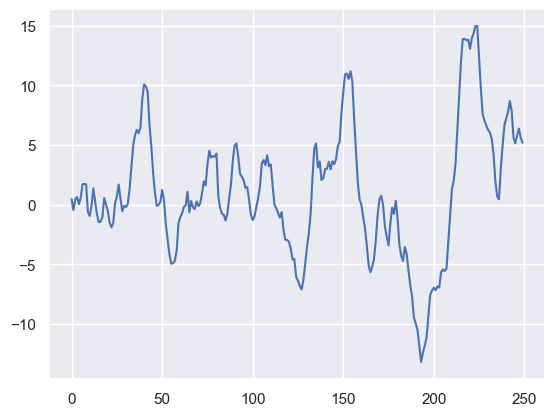

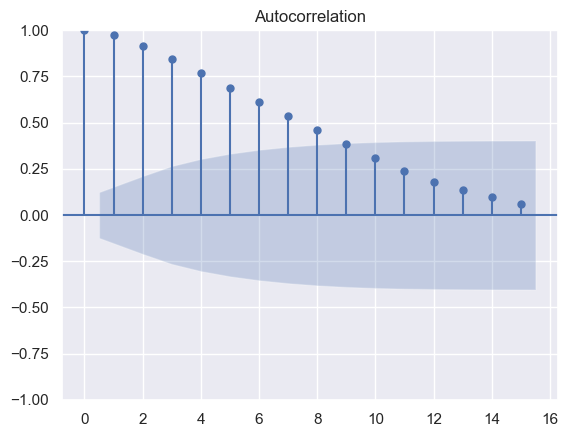

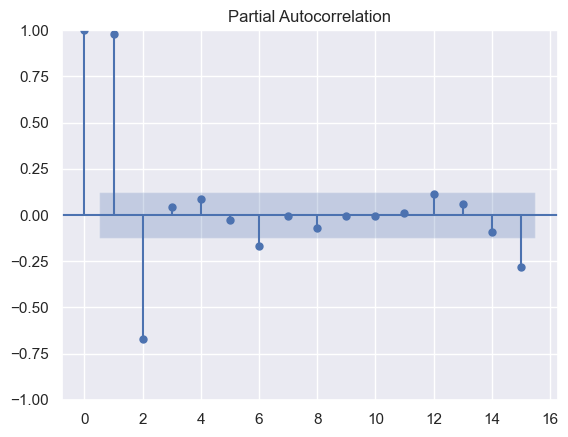

In [10]:
np.random.seed(1234)
AR_series = sim_dataset(2, 0, 250, polynomial_root=-0.8)
plt.plot(AR_series)
plt.show()
sm.graphics.tsa.plot_acf(AR_series, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(AR_series, lags=15)
plt.show()


#### MA

ACF: Significant terms up to the MA term, then no significant pattern
PACF: Exponentially decaying terms


ARMA process is stationary:  True
ARMA process is invertible:  True


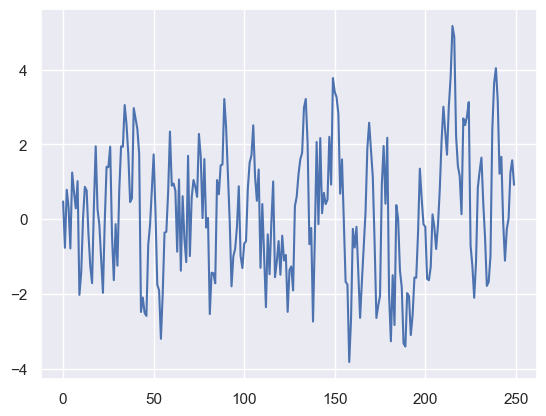

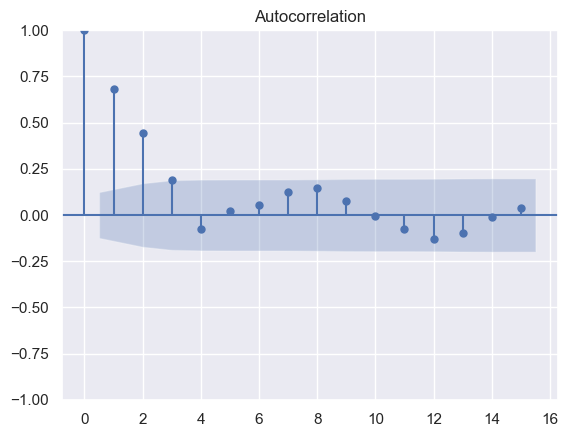

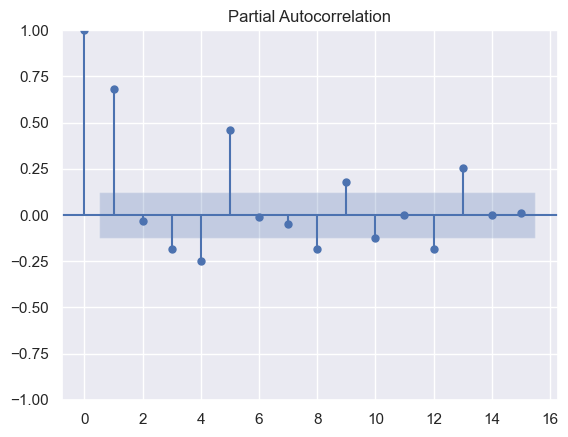

In [11]:
np.random.seed(1234)
MA_series = sim_dataset(0, 3, 250, MA_weight=0.9)
plt.plot(MA_series)
plt.show()
sm.graphics.tsa.plot_acf(MA_series, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(MA_series, lags=15)
plt.show()


#### ARMA

ACF: Exponentially decaying terms
PACF: Exponentially decaying terms


ARMA process is stationary:  True
ARMA process is invertible:  True


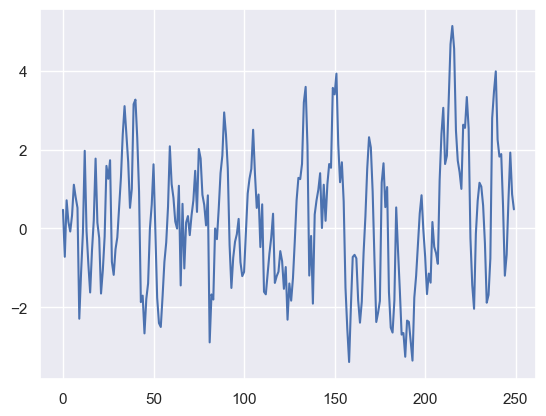

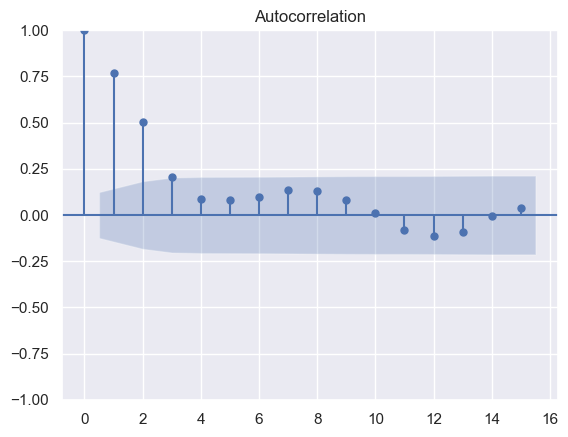

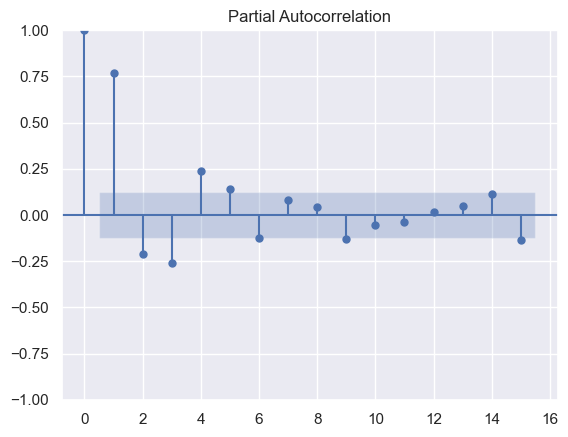

In [12]:
np.random.seed(1234)
ARMA_series = sim_dataset(1, 2, 250, polynomial_root=-0.5)
plt.plot(ARMA_series)
plt.show()
sm.graphics.tsa.plot_acf(ARMA_series, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(ARMA_series, lags=15)
plt.show()


## Interpretation:

We can recognize some features of AR/MA models from the ACF and PACF plots.

AR is easy to recognize; can be harder to interpret PACF when the sign changes between terms.


## Fitting ARIMA Models

Estimating these models can be challenging. Luckily, there are open source tools we can use to estimate AR/MA terms.

Here, we use the ARIMA package to fit models to the data. Python has some other options, to better suit cases with periodic components.


Estimation goal: given an order $p, q$, find estimates of $\phi$ and $\theta$

Recall the general form for an AR model of order $p$:
$$X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} \dots + \phi_p X_{t - p} + \varepsilon_t$$

And the form for an MA model of order $q$:
$$X_t = \varepsilon_t + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} \dots + \theta_q \varepsilon_{t-1}$$

where $ɛ_t$ is mean zero white noise that's uncorrelated with any lagged or future values.


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -351.516
Date:                Tue, 11 Apr 2023   AIC                            711.032
Time:                        17:14:39   BIC                            725.118
Sample:                             0   HQIC                           716.701
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2190      1.508      0.808      0.419      -1.737       4.175
ar.L1          1.5431      0.058     26.696      0.000       1.430       1.656
ar.L2         -0.5853      0.057    -10.249      0.0

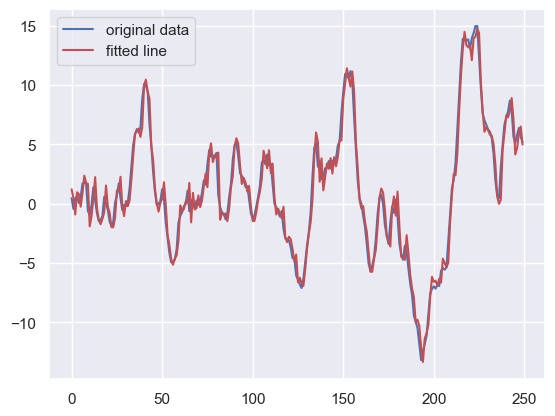

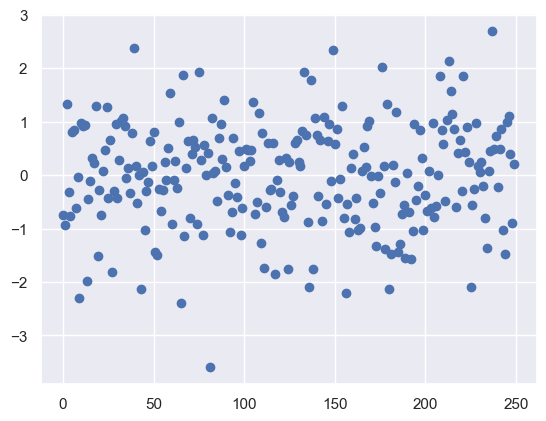

MSE with AR(1) model: 0.9632736339947159
AIC with AR(1) model: 706.1148265858366
BIC with AR(1) model: 716.6792093394233


In [13]:
from statsmodels.tsa.arima.model import ARIMA
AR_order = 2

ar_higher = ARIMA(AR_series, order=(AR_order, 0, 0)).fit()
print(ar_higher.summary())

ar_higher_predictions = ar_higher.predict()
ar_higher_residuals = AR_series - ar_higher_predictions

# Fitting AR 1 model means removing one observation
ar_higher_residuals = ar_higher_residuals

plt.plot(AR_series, label='original data')
plt.plot(ar_higher_predictions, 'r', label='fitted line')
plt.legend()
plt.show()
plt.plot(ar_higher_residuals, 'o')
plt.show()
print("MSE with AR(1) model:", np.mean(ar_higher_residuals**2))
print("AIC with AR(1) model:", evaluate_AIC(AR_order + 1, ar_higher_residuals))
print("BIC with AR(1) model:", evaluate_BIC(AR_order + 1, ar_higher_residuals))


#### Comment on model fit

From the graph, it looks like the model fits really well - the lines are basically overlapping!

From the residuals, we still have very large magnitudes, relative to the values in the time series. What's going on?

Look more closely at the time series to get an idea of what's happening


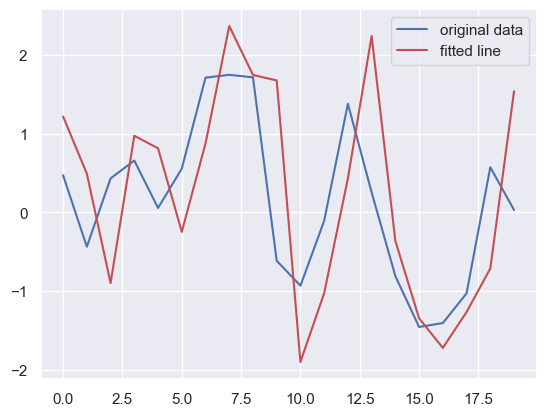

In [14]:
plt.plot(AR_series[:20], label='original data')
plt.plot(ar_higher_predictions[:20], 'r', label='fitted line')
plt.legend()
plt.show()


In [15]:
def grid_search_ARIMA(data, AR_range, MA_range, verbose=False):
    min_aic = np.inf
    min_bic = np.inf
    min_aic_index = None
    min_bic_index = None
    aic_matrix = np.zeros((len(AR_range), len(MA_range)))
    bic_matrix = np.zeros((len(AR_range), len(MA_range)))
    for AR_order in AR_range:
        for MA_order in MA_range:
            arma = ARIMA(data, order=(AR_order, 0, MA_order)).fit()
            aic_matrix[AR_order, MA_order] = arma.aic
            bic_matrix[AR_order, MA_order] = arma.bic
            if arma.aic < min_aic:
                min_aic = arma.aic
                min_aic_index = (AR_order, 0, MA_order)
            if arma.bic < min_bic:
                min_bic = arma.bic
                min_bic_index = (AR_order, 0, MA_order)
    if verbose:
        print("Minimizing AIC order: ", min_aic_index)
        print("Minimizing BIC order: ", min_bic_index)
        print("matrix of AIC", aic_matrix)
        print("Matrix of BIC", bic_matrix)
    return min_aic_index, min_bic_index, aic_matrix, bic_matrix


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-pack

Minimizing AIC order:  (2, 0, 0)
Minimizing BIC order:  (2, 0, 0)
matrix of AIC [[1553.78272918 1255.25060081 1057.21735204  914.82988836]
 [ 814.38492835  740.89378902  720.55623289  714.35754726]
 [ 711.03231248  712.86832543  714.07618607  715.90615242]
 [ 712.84223033  714.69648877  716.06319733  711.73997256]]
Matrix of BIC [[1560.82565102 1265.81498356 1071.30319571  932.43719295]
 [ 824.9493111   754.97963269  738.16353748  735.48631277]
 [ 725.11815616  730.47563002  735.20495158  740.55637885]
 [ 730.44953492  735.82525428  740.71342375  739.9116599 ]]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -351.516
Date:                Tue, 11 Apr 2023   AIC                            711.032
Time:                        17:19:01   BIC                            725.118
Sample:                             0

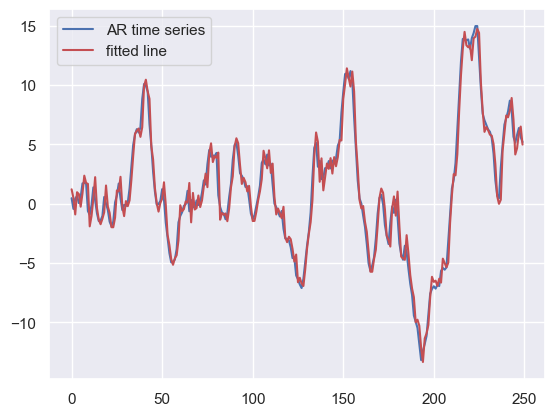

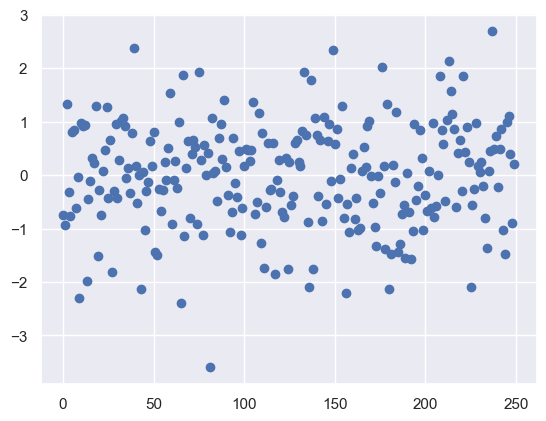

Automatic selection finds model with AR 2, MA 0
MSE with selected model: 0.9632736339947159


In [16]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(
    AR_series,
    range(4),
    range(4),
    verbose=True
)

if min_aic_index == min_bic_index:
    arma = ARIMA(AR_series, order=min_bic_index).fit()
    print(arma.summary())

    arma_predictions = arma.predict()
    arma_residuals = AR_series - arma_predictions
    arma_residuals = arma_residuals  # Fitting AR 1 model means removing one observation

    plt.plot(AR_series, label='AR time series')
    plt.plot(arma_predictions, 'r', label='fitted line')
    plt.legend()
    plt.show()
    plt.plot(arma_residuals, 'o')
    plt.show()
    print("Automatic selection finds model with AR {0}, MA {2}".format(
        *min_aic_index))
    print("MSE with selected model:", np.mean(arma_residuals**2))
else:
    print("AIC, BIC do not agree.")


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packa

Minimizing AIC order:  (0, 0, 3)
Minimizing BIC order:  (0, 0, 3)
matrix of AIC [[986.90922409 862.24295047 841.89257746 705.22866979]
 [834.38150984 836.19113675 786.942553   705.47905742]
 [836.09410819 810.27377651 762.14749058 707.46074908]
 [829.78701607 829.05395877 757.13459289 709.59895899]]
Matrix of BIC [[993.95214593 872.80733323 855.97842114 722.83597438]
 [844.9458926  850.27698042 804.54985759 726.60782292]
 [850.17995186 827.8810811  783.27625609 732.11097551]
 [847.39432066 850.18272428 781.78481932 737.77064633]]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(0, 0, 3)   Log Likelihood                -347.614
Date:                Tue, 11 Apr 2023   AIC                            705.229
Time:                        17:19:32   BIC                            722.836
Sample:                             0   HQIC                         

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


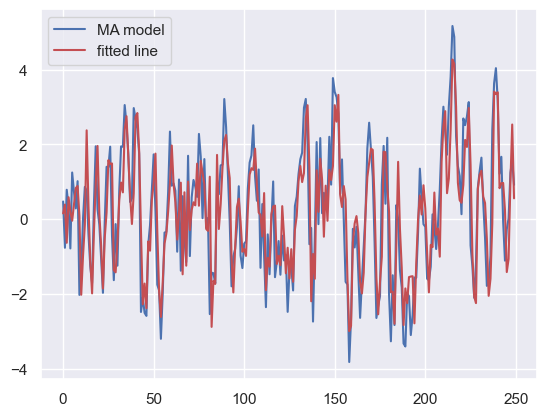

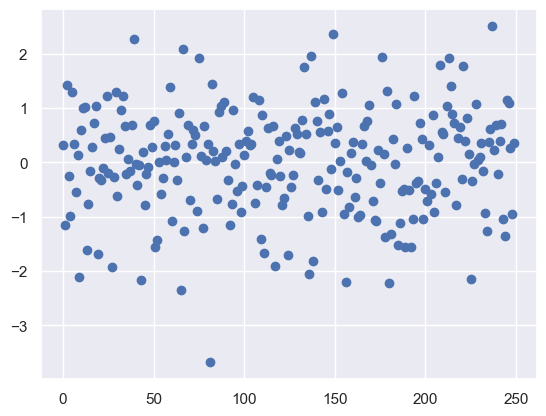

Automatic selection finds model with AR 0, MA 3
MSE with selected model: 0.9390703470415098


In [17]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(
    MA_series,
    range(4),
    range(4),
    verbose=True
)

if min_aic_index == min_bic_index:
    arma = ARIMA(MA_series, order=min_bic_index).fit()
    print(arma.summary())
    arma_predictions = arma.predict()
    arma_residuals = MA_series - arma_predictions
    arma_residuals = arma_residuals
    plt.plot(MA_series, label='MA model')
    plt.plot(arma_predictions, 'r', label='fitted line')
    plt.legend()
    plt.show()
    plt.plot(arma_residuals, 'o')
    plt.show()
    print("Automatic selection finds model with AR {0}, MA {2}".format(
        *min_aic_index))
    print("MSE with selected model:", np.mean(arma_residuals**2))
else:
    print("AIC, BIC do not agree.")


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\s

Minimizing AIC order:  (1, 0, 2)
Minimizing BIC order:  (1, 0, 2)
matrix of AIC [[973.85586927 836.84084996 727.99939636 712.21420308]
 [755.1614623  750.89153123 709.47226897 711.46669608]
 [746.14093803 743.51132856 711.46698331 710.73467075]
 [731.98360613 728.5315214  713.45942566 714.42139705]]
Matrix of BIC [[980.89879111 847.40523272 742.08524003 729.82150767]
 [765.72584506 764.9773749  727.07957356 732.59546159]
 [760.2267817  761.11863315 732.59574881 735.38489718]
 [749.59091072 749.66028691 738.10965209 742.59308439]]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -349.736
Date:                Tue, 11 Apr 2023   AIC                            709.472
Time:                        17:20:35   BIC                            727.080
Sample:                             0   HQIC                         

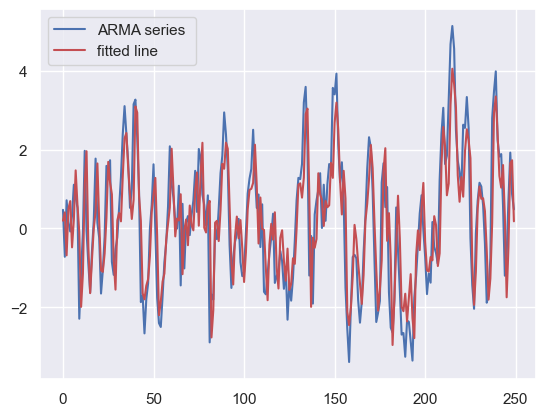

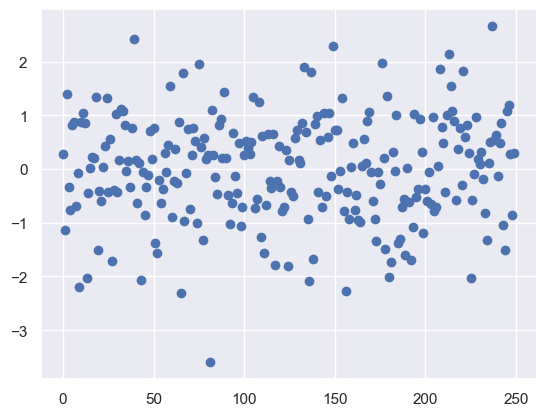

Automatic selection finds model with AR 1, MA 2
MSE with selected model: 0.9571736182678612


In [18]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(
    ARMA_series, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
    arma = ARIMA(ARMA_series, order=min_bic_index).fit()
    print(arma.summary())
    arma_predictions = arma.predict()
    arma_residuals = ARMA_series - arma_predictions
    arma_residuals = arma_residuals
    plt.plot(ARMA_series, label='ARMA series ')
    plt.plot(arma_predictions, 'r', label='fitted line')
    plt.legend()
    plt.show()
    plt.plot(arma_residuals, 'o')
    plt.show()
    print("Automatic selection finds model with AR {0}, MA {2}".format(
        *min_aic_index))
    print("MSE with selected model:", np.mean(arma_residuals**2))
else:
    print("AIC, BIC do not agree.")


#### Aside: What if AIC/BIC don't agree?

Here's an illustration where this doesn't work - the answer is to use a more complicated tool to assess model fit, such as cross validation with a rolling forecast window.

We won't go over this example, but it's here if you're interested. Try to play with the model settings and find what helps AIC/BIC select an appropriate model.

We don't cover such methods in this course, but you can look up data science blogs or textbooks for approaches to this topic.


ARMA process is stationary:  True
ARMA process is invertible:  True


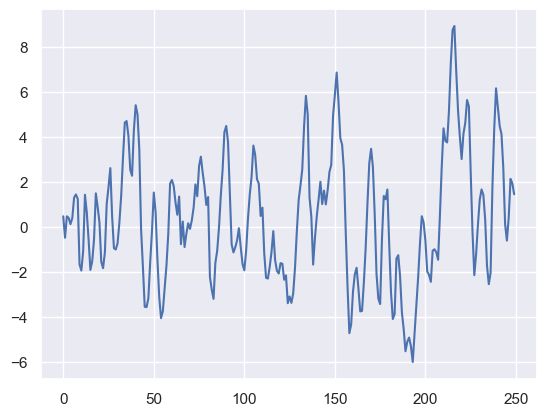

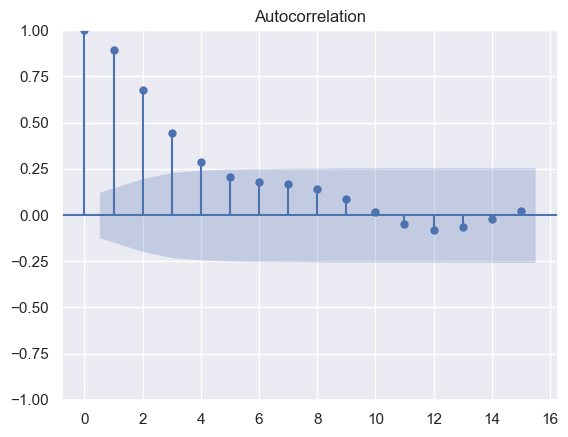

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


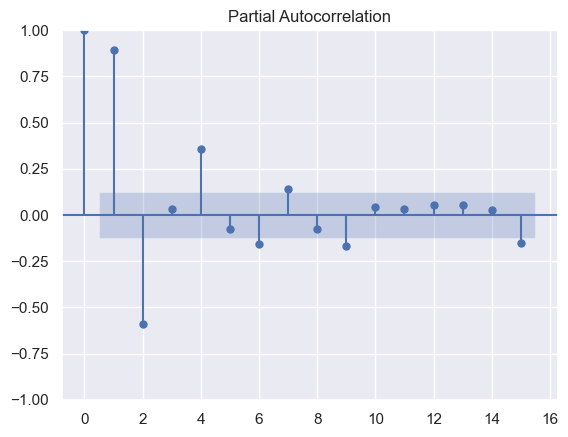

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-pack

Minimizing AIC order:  (2, 0, 2)
Minimizing BIC order:  (1, 0, 2)
matrix of AIC [[1230.177846    992.93279633  833.45884984  743.90285356]
 [ 837.93096778  778.1142701   714.1535879   712.37826363]
 [ 744.21977832  746.18666807  712.35419478  714.31986607]
 [ 746.14838714  744.09104363  714.32068092  715.78666861]]
Matrix of BIC [[1237.22076784 1003.49717909  847.54469351  761.51015815]
 [ 848.49535054  792.20011377  731.76089249  733.50702913]
 [ 758.30562199  763.79397266  733.48296029  738.97009249]
 [ 763.75569173  765.21980914  738.97090735  743.95835596]]
AIC, BIC do not agree.


In [19]:
np.random.seed(1234)
ARMA_series_alt = sim_dataset(2, 2, 250, polynomial_root=-0.5)
plt.plot(ARMA_series_alt)
plt.show()
sm.graphics.tsa.plot_acf(ARMA_series_alt, lags=15)
plt.show()
sm.graphics.tsa.plot_pacf(ARMA_series_alt, lags=15)
plt.show()

min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(
    ARMA_series_alt, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
    arma = ARIMA(ARMA_series, order=min_bic_index).fit()
    print(arma.summary())
    arma_predictions = arma.predict()
    arma_residuals = ARMA_series - arma_predictions
    arma_residuals = arma_residuals  # Fitting AR 1 model means removing one observation
    plt.plot(ARMA_series, label='ARMA series ')
    plt.plot(arma_predictions, 'r', label='fitted line')
    plt.legend()
    plt.show()
    plt.plot(arma_residuals, 'o')
    plt.show()
    print("Automatic selection finds model with AR {0}, MA {2}".format(
        *min_aic_index))
    print("MSE with selected model:", np.mean(arma_residuals**2))
else:
    print("AIC, BIC do not agree.")


### Recap on model fitting:

We can use Python packages to fit ARIMA models, and our AIC/BIC procedure seems to select the correct model used to generate the time series.

What we've found is estimates of these coefficients in our AR/MA model:
$$X_t = \hat{\phi}_1 X_{t-1} + \hat{\phi}_2 X_{t-2} \dots + \hat{\phi}_p X_{t - p} + \hat{\theta}_1 \varepsilon_{t-1} + \hat{\theta}_2 \varepsilon_{t-2} \dots + \hat{\theta}_q \varepsilon_{t-q} + \varepsilon_t $$


## Forming forecasts:

Now that we found a model, we can form forecasts.

With estimates of each $\theta$ and $\phi$ term, we can predict one step ahead.

$$\hat{X}_{t + 1} = \hat{\phi}_1 X_{t} + \hat{\phi}_2 X_{t-1} \dots + \hat{\phi}_p X_{t - p + 1} + \hat{\theta}_1 \varepsilon_{t} + \hat{\theta}_2 \varepsilon_{t-1} \dots + \hat{\theta}_q \varepsilon_{t-q + 1} $$

To form long-range forecasts, we can just plug in our estimate $\hat{X}_{t + 1}$ in place of $X_{t + 1}$ at every future value, and so on for other future estimates. Let's see what happens when we do this:


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -349.736
Date:                Tue, 11 Apr 2023   AIC                            709.472
Time:                        17:23:45   BIC                            727.080
Sample:                             0   HQIC                           716.559
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1964      0.224      0.878      0.380      -0.242       0.635
ar.L1          0.4084      0.088      4.652      0.000       0.236       0.581
ma.L1          0.5164      0.075      6.917      0.0

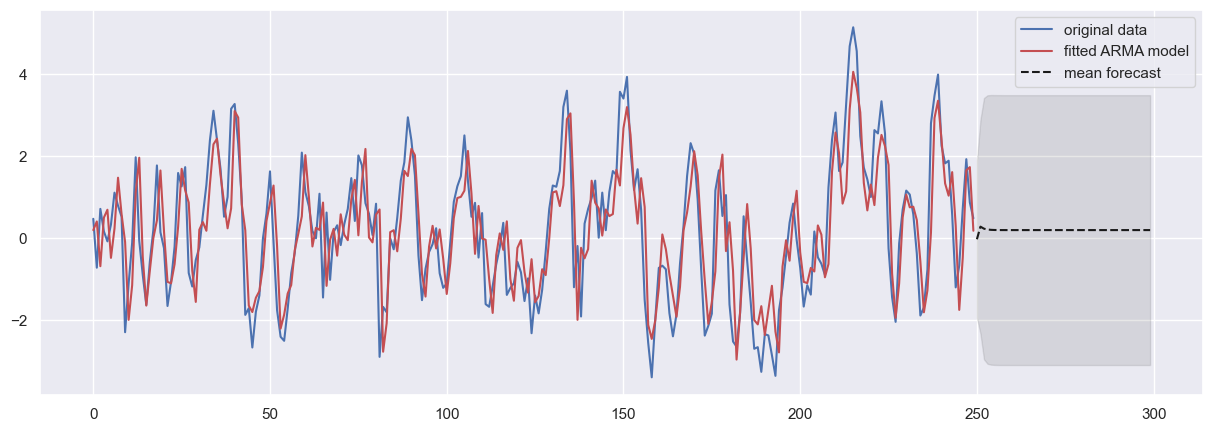

In [20]:
arma = ARIMA(ARMA_series, order=min_bic_index).fit()
print(arma.summary())
arma_predictions = arma.predict()
fcast = arma.get_forecast(50).summary_frame()

fig, ax = plt.subplots(figsize=(15, 5))

arma_predictions = arma.predict()
ax.plot(np.arange(len(ARMA_series)), ARMA_series, label='original data')
predicted_values = arma_predictions.reshape(-1, 1)
ax.plot(np.arange(len(ARMA_series)), predicted_values,
        'r', label='fitted ARMA model')
forecast_means = fcast['mean'].values.reshape(-1, 1)
forecast_x_vals = np.arange(len(ARMA_series), len(ARMA_series) + 50)
ax.plot(forecast_x_vals, forecast_means, 'k--', label='mean forecast')
ax.fill_between(forecast_x_vals, fcast['mean_ci_lower'],
                fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.legend()


### Why do long-term predictions revert to the mean?

Eventually, a future prediction in the time series will rely completely on predicted $X$ values.

For any stationary time series, the long-range predictions will converge to the mean.


#### Aside:

How are these confidence regions formed? It comes from the variability in our estimates of $\hat{\phi}$ and $\hat{\theta}$.

It gets pretty complicated to keep track of the standard error in estimating these things - as is often the case, we're lucky to have open source tools that calculate these confidence intervals for us.


## Return to Our Problem

Now, we'll apply what we've learned to study the stock price forecasting example we started with earlier.


[[ 2.25079419e-03 -5.29048183e-07]]


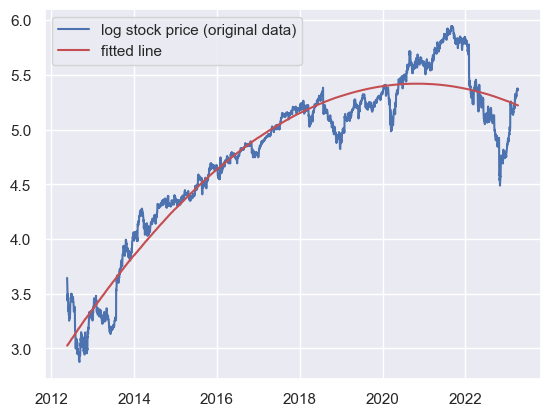

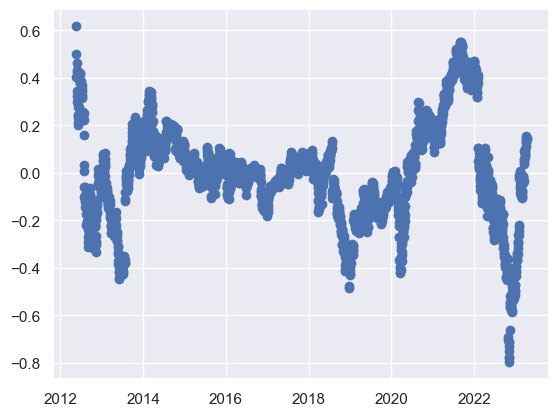

MSE with quadratic fit: 0.04336902800087181
AIC: -818.6636395945284
BIC: -806.8314834019228


In [21]:
# After linear fit, it seems like a higher order model is needed
from sklearn import linear_model
clf = linear_model.LinearRegression()
index = fb_series.reset_index().index.values.reshape(-1, 1)

new_x = np.hstack((index, index ** 2))
clf.fit(new_x, log_price)
print(clf.coef_)  # To print the coefficient estimate of the series.
quad_prediction = clf.predict(new_x)
plt.plot(date, log_price, label='log stock price (original data)')
plt.plot(date, quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
quad_residuals = log_price - quad_prediction
plt.plot(date, quad_residuals, 'o')
plt.show()
print("MSE with quadratic fit:", np.mean((quad_residuals)**2))
print("AIC:", evaluate_AIC(2, quad_residuals))
print("BIC:", evaluate_BIC(2, quad_residuals))


Resuming from after finding this model fit - let's look at the ACF/PACF one more time.


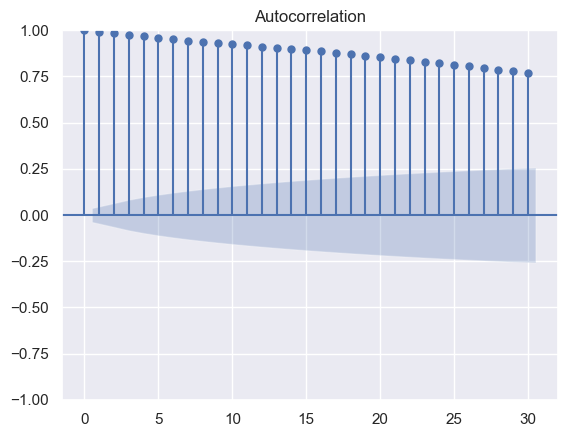

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


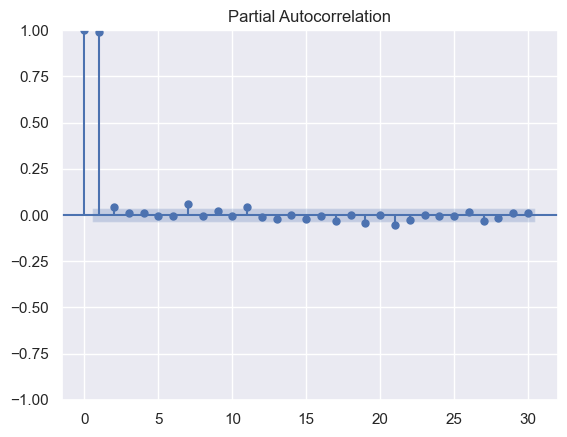

In [22]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(quad_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(quad_residuals, lags=30)
plt.show()


This clearly suggests an AR 1 model: there are two significant terms in the PACF, and a slowly decaying ACF.

We can confirm by doing a grid search over possible values:


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\s

Minimizing AIC order:  (1, 0, 0)
Minimizing BIC order:  (1, 0, 0)
matrix of AIC [[  -818.66363617  -4169.00367582  -6436.78476067  -7989.49825135]
 [-12294.01078352 -12293.30663216 -12292.20641898 -12292.0356518 ]
 [-12293.14970592 -12292.50640979 -12291.72066654 -12291.12142644]
 [-12292.36319888 -12290.62838855 -12293.67119242 -12287.89323799]]
Matrix of BIC [[  -806.83147998  -4151.25544153  -6413.12044828  -7959.91786087]
 [-12276.26254923 -12269.64231978 -12262.6260285  -12256.53918323]
 [-12269.48539354 -12262.92601931 -12256.22419796 -12249.70887976]
 [-12262.7828084  -12255.13191997 -12252.25864574 -12240.56461322]]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2741
Model:                 ARIMA(1, 0, 0)   Log Likelihood                6150.005
Date:                Tue, 11 Apr 2023   AIC                         -12294.011
Time:                        17:27:41   BIC         

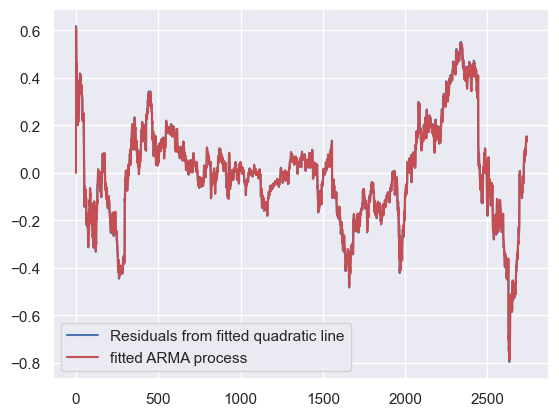

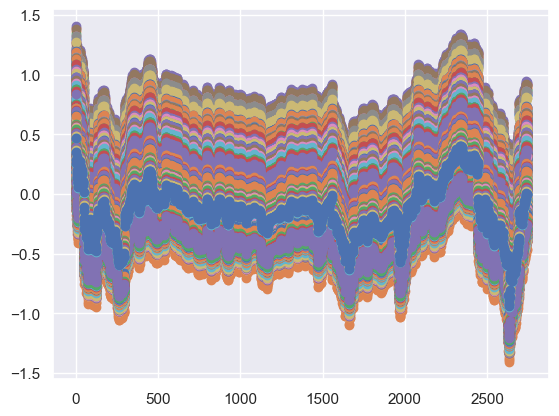

Automatic selection finds model with AR 1, MA 0
MSE with selected model: 0.08594330428578557


In [23]:
min_aic_index, min_bic_index, _, _ = grid_search_ARIMA(
    quad_residuals, range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
    arma = ARIMA(quad_residuals, order=min_bic_index).fit()
    print(arma.summary())
    arma_predictions = arma.predict()
    arma_residuals = quad_residuals - arma_predictions
    arma_residuals = arma_residuals  # Fitting AR 1 model means removing one observation
    plt.plot(quad_residuals, label='Residuals from fitted quadratic line')
    plt.plot(arma_predictions, 'r', label='fitted ARMA process')
    plt.legend()
    plt.show()
    plt.plot(arma_residuals, 'o')
    plt.show()
    print("Automatic selection finds model with AR {0}, MA {2}".format(
        *min_aic_index))
    print("MSE with selected model:", np.mean(arma_residuals**2))
else:
    print("AIC, BIC do not agree.")


### Evaluate with Test Set

Here, we see how well this predicts future values; we set an arbitrary value of 20% of the series. In practice, you would likely use rolling windows to assess the performance more credibly, since 20% of the series can actually be much further than the model predicts.

An illustration of rolling windows: for $t = 1, \dots, 100$, train a model on steps $t = 1, \dots, 20$, then predict on $t = 21, \dots, 40$. Then train the model on $t = 1, \dots, 40$ and predict on $t = 41, \dots, 60$, and so on.


In [24]:
train_test_split = int(len(price) * 0.8)
train_price, test_price = quad_residuals[:
                                         train_test_split], quad_residuals[train_test_split:]
train_date, test_date = date[:train_test_split], date[train_test_split:]
assert (len(train_date) + len(test_date) == len(date))


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2192
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5120.433
Date:                Tue, 11 Apr 2023   AIC                         -10234.866
Time:                        17:29:02   BIC                         -10217.788
Sample:                             0   HQIC                        -10228.624
                               - 2192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.027      0.247      0.805      -0.047       0.060
ar.L1          0.9852      0.002    633.058      0.000       0.982       0.988
sigma2         0.0005   6.07e-06     90.029      0.0

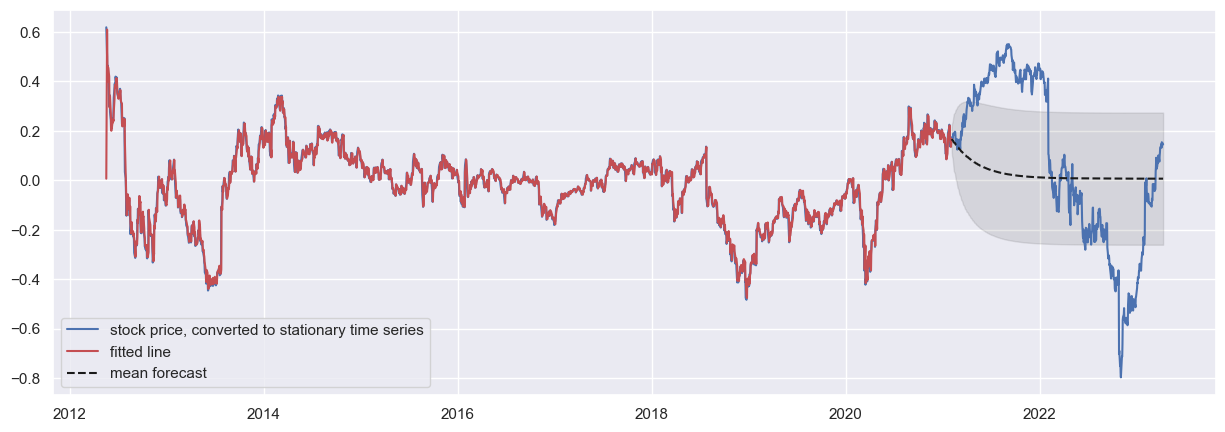

In [25]:
# First, let's see how this does with the AIC selected values.
arma = ARIMA(train_price, order=min_aic_index).fit()
print(arma.summary())
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(test_price)).summary_frame()

arma_predictions = arma.predict()
ax.plot(date, quad_residuals,
        label='stock price, converted to stationary time series')
predicted_values = arma_predictions.reshape(-1, 1)
ax.plot(train_date, predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1, 1)
test_set_mse = np.mean(
    (forecast_means.reshape(test_price.shape) - test_price)**2)
ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
ax.fill_between(test_date.flatten(
), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.legend()
print("Test set mean squared error: ", test_set_mse)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2192
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5120.433
Date:                Tue, 11 Apr 2023   AIC                         -10234.866
Time:                        17:31:16   BIC                         -10217.788
Sample:                             0   HQIC                        -10228.624
                               - 2192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.027      0.247      0.805      -0.047       0.060
ar.L1          0.9852      0.002    633.058      0.000       0.982       0.988
sigma2         0.0005   6.07e-06     90.029      0.0

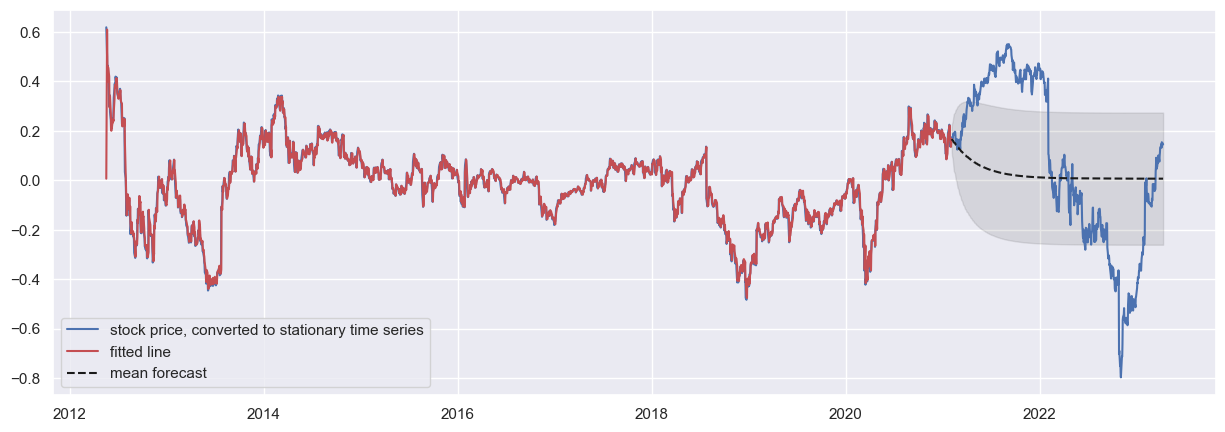

In [26]:
# Now, let's see how this does with the BIC selected values.
arma = ARIMA(train_price, order=min_bic_index).fit()
print(arma.summary())
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(test_price)).summary_frame()

arma_predictions = arma.predict()
ax.plot(date, quad_residuals,
        label='stock price, converted to stationary time series')
predicted_values = arma_predictions.reshape(-1, 1)
ax.plot(train_date, predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1, 1)
test_set_mse = np.mean(
    (forecast_means.reshape(test_price.shape) - test_price)**2)
ax.plot(test_date, forecast_means, 'k--', label='mean forecast')
ax.fill_between(test_date.flatten(
), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.legend()
print("Test set mean squared error: ", test_set_mse)


### Interpretation:

The BIC selected value has a lower test-set mean squared error.
Using daily values, the best predictor of stock price uses the AR(1) model, and has a coefficient of 0.9923. That is, the best predictor of tomorrow's stock price, is 0.9923 times today's stock price (after taking logs and removing the quadratic trend)

Turns out, the conclusion we get from looking at the ACF/PACF plots was more accurate than just doing a grid search over these values.


### Extension: Monthly Predictions

If you're interested in long-range forecasts, it might be better to convert the time series to monthly values.

This loses lots of rich variation, but avoids the problem where predictions one month away will have converged to the mean of the series.

Here, we show how to manipulate the time series to do this alternate procedure.

We follow the same steps: convert to stationary, model the AR/MA components, and then form predictions.


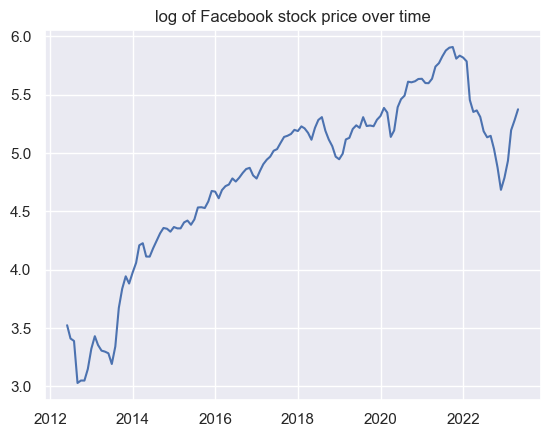

In [27]:
collapsed = fb_series.groupby(pd.Grouper(freq='M')).mean()
month_date = collapsed.reset_index().Date.dt.date.values.reshape(-1, 1)
month_price = collapsed.High.values.reshape(-1, 1)
month_log_price = np.log(month_price)
plt.plot(month_date, month_log_price)
plt.title("log of Facebook stock price over time")
plt.show()


[[ 0.04608297 -0.00022424]]


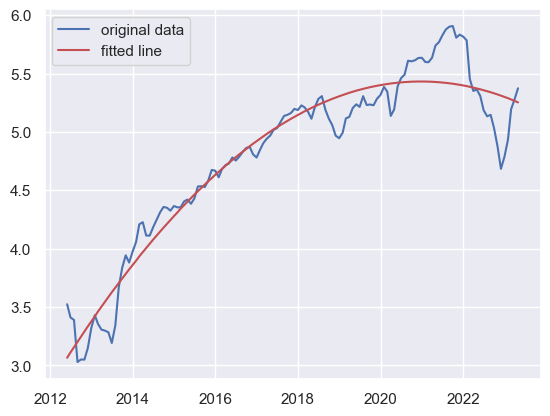

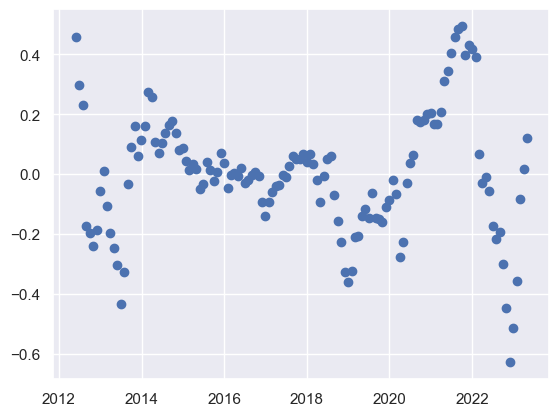

MSE with quadratic fit: 0.041664271441898985


In [28]:
clf = linear_model.LinearRegression()
index = collapsed.reset_index().index.values.reshape(-1, 1)
new_x = np.hstack((index, index ** 2))
clf.fit(new_x, month_log_price)
print(clf.coef_)  # To print the coefficient estimate of the series.
month_quad_prediction = clf.predict(new_x)
plt.plot(month_date, month_log_price, label='original data')
plt.plot(month_date, month_quad_prediction, 'r', label='fitted line')
plt.legend()
plt.show()
month_quad_residuals = month_log_price - month_quad_prediction
plt.plot(month_date, month_quad_residuals, 'o')
plt.show()
print("MSE with quadratic fit:", np.mean((month_quad_residuals)**2))


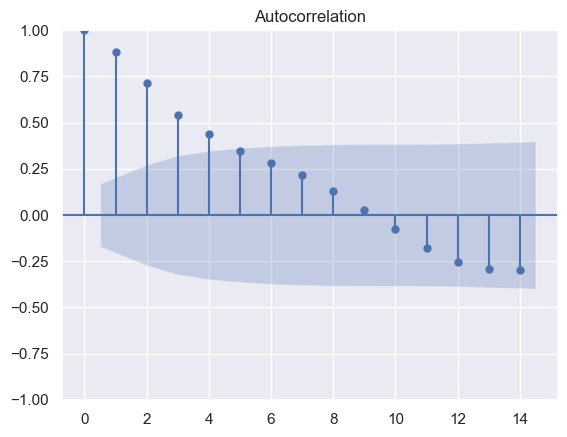

c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


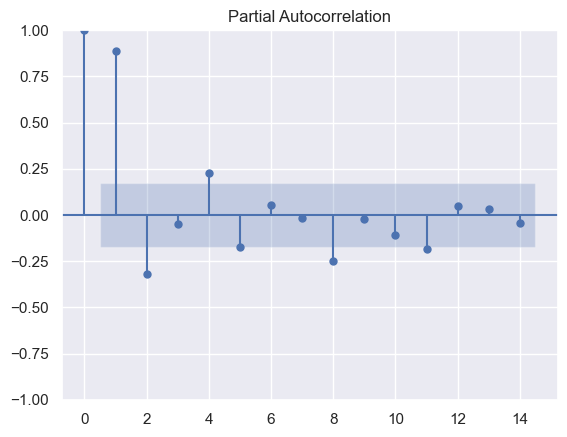

In [29]:
sm.graphics.tsa.plot_acf(month_quad_residuals, lags=14)
plt.show()
sm.graphics.tsa.plot_pacf(month_quad_residuals, lags=14)
plt.show()


In [30]:
month_train_test = int(0.8 * len(month_date))
month_train, month_test = month_quad_residuals[:
                                               month_train_test], month_quad_residuals[month_train_test:]
month_date_train, month_date_test = month_date[:
                                               month_train_test], month_date[month_train_test:]


In [31]:
min_aic_index, min_bic_index, * \
    other = grid_search_ARIMA(month_quad_residuals,
                              range(4), range(4), verbose=True)
if min_aic_index == min_bic_index:
    arma = ARIMA(month_quad_residuals, order=min_bic_index).fit()
    print(arma.summary())
    arma_predictions = arma.predict()
    arma_residuals = month_quad_residuals.reshape(
        arma_predictions.shape) - arma_predictions
    arma_residuals = arma_residuals  # Fitting AR 1 model means removing one observation
    plt.plot(month_quad_residuals, label='Residuals from fitted quadratic line')
    plt.plot(arma_predictions, 'r', label='fitted ARMA process')
    plt.legend()
    plt.show()
    plt.plot(arma_residuals, 'o')
    plt.show()
    print("Automatic selection finds model with AR {0}, MA {2}".format(
        *min_aic_index))
    print("MSE with selected model:", np.mean(arma_residuals**2))
else:
    print("AIC, BIC do not agree.")


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-pack

Minimizing AIC order:  (2, 0, 2)
Minimizing BIC order:  (2, 0, 0)
matrix of AIC [[ -40.91092105 -165.0133807  -245.7599257  -254.94121927]
 [-257.53971834 -275.00588731 -279.66439691 -278.91483402]
 [-280.07576049 -278.07787679 -280.4136907  -278.65438129]
 [-278.07826934 -276.71462992 -280.06153297 -277.37087002]]
Matrix of BIC [[ -35.14531721 -156.36497493 -234.22871801 -240.52720966]
 [-248.89131257 -263.47467962 -265.2503873  -261.61802249]
 [-268.5445528  -263.66386718 -263.11687917 -258.47476783]
 [-263.66425973 -259.41781839 -259.88191951 -254.30845464]]
AIC, BIC do not agree.


c:\Users\eddysanoli\AppData\Local\pypoetry\Cache\virtualenvs\data_analysis-ayydRhdv-py3.9\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test set mean squared error:  0.1073650377521827


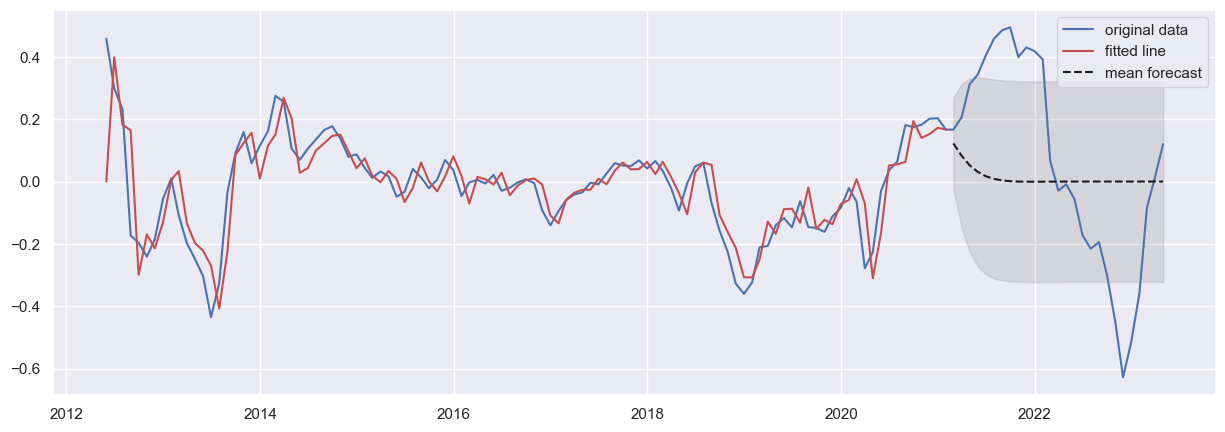

In [32]:
arma = ARIMA(month_train, order=min_bic_index).fit()
fig, ax = plt.subplots(figsize=(15, 5))

# Construct the forecasts
fcast = arma.get_forecast(len(month_test)).summary_frame()

arma_predictions = arma.predict()
ax.plot(month_date, month_quad_residuals, label='original data')
predicted_values = arma_predictions.reshape(-1, 1)
ax.plot(month_date_train, predicted_values, 'r', label='fitted line')
forecast_means = fcast['mean'].values.reshape(-1, 1)
ax.plot(month_date_test, forecast_means, 'k--', label='mean forecast')
ax.fill_between(month_date_test.flatten(
), fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.legend()

test_set_mse = np.mean(
    (forecast_means.reshape(month_test.shape) - month_test)**2)
print("Test set mean squared error: ", test_set_mse)
